In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import cosine
from scipy.stats import ks_2samp

______________________________

In [2]:
network = 'tarbase'
target_homology = 'mix'

lca_source = 'mirgenedb'  # Options: 'mirgenedb' or 'ensembl'

remove_SSD_pre_2R = False
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

if remove_SSD_pre_2R:
	s = 'post_2R'
elif keep_SSD_pre_2R:
	s = 'pre_2R'
else:
	s = ''

remove_large_fam = False
if remove_large_fam:
	max_n_nodes = 4
	s += f'cc_largerthan{str(max_n_nodes)}_removed'

remove_undistinguished_pairs = True
if remove_undistinguished_pairs:
	s += '_undistinguished_pairs_removed'

print("ID string:", s)

ID string: _undistinguished_pairs_removed


In [3]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [4]:
ensembl_mirna_pair_lca_file_path = '../../3_retrieve_Hsa_paralogs/all_hsa_ensembl_paralogmirna_clean.tsv'
df_mirna_pair_lca = pd.read_csv(ensembl_mirna_pair_lca_file_path, sep='\t', header=None)
ensembl_pair_lca_dict = {}
for _, row in df_mirna_pair_lca.iterrows():
	ensembl_pair_lca_dict[(row[1], row[3])] = row[4]
	ensembl_pair_lca_dict[(row[3], row[1])] = row[4]

In [5]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirgenedb_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin[[8, 14, 15]]
df_mirgenedb_mirna_origin = df_mirgenedb_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirgenedb_mirna_origin.columns = cols
df_mirgenedb_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirgenedb_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

In [6]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'Homo_sapiens': 21
}

reverted_ordered_lca_dict = {v: k for k, v in ordered_lca.items()}

In [7]:
df_wgd = df_1
df_ssd = df_2

In [8]:
if remove_undistinguished_pairs:
	df_wgd = df_wgd[~((df_wgd['n_common_targets'] == df_wgd['n_tar_1']) & (df_wgd['n_common_targets'] == df_wgd['n_tar_2']))]
	df_ssd = df_ssd[~((df_ssd['n_common_targets'] == df_ssd['n_tar_1']) & (df_ssd['n_common_targets'] == df_ssd['n_tar_2']))]

In [9]:
def add_ensembl_lca(df, dict):
    df_cp = df.copy()
    df_cp['lca'] = df_cp.apply(lambda row: dict.get((row['miRNA_1'], row['miRNA_2'])), axis=1)
    return df_cp

def add_mirgenedb_lca(df, single_miRNA_dict, dict):
	reverted_dict = {v: k for k, v in dict.items()}
	def compute_max_lca(miRNA):
		# If the miRNA value itself is NaN/null, skip immediately
		if pd.isna(miRNA):
			return -1
		# Look up its list of lno’s; if that’s not a list/tuple, treat as empty
		lno_list = single_miRNA_dict.get(miRNA, [])
		if not isinstance(lno_list, (list, tuple)):
			return -1
		# Map to ordered_lca values and take the max (or -1 if empty)
		return max((dict.get(lno, -1) for lno in lno_list), default=-1)
    
	df_cp = df.copy()
	df_cp['lca_1'] = df_cp['miRNA_1'].apply(compute_max_lca)
	df_cp['lca_2'] = df_cp['miRNA_2'].apply(compute_max_lca)
	df_cp['lca_code'] = df_cp[['lca_1', 'lca_2']].max(axis=1)
	df_cp = df_cp.drop(columns=['lca_1', 'lca_2'])
	df_cp['lca'] = df_cp['lca_code'].apply(
		lambda code: reverted_dict.get(code, 'Unknown')
	)
	df_cp = df_cp.drop(columns=['lca_code'])
	return df_cp

if lca_source == "ensembl":
    print("Using Ensembl for LCA")
    df_wgd_lca = add_ensembl_lca(df_wgd, ensembl_pair_lca_dict)
    df_ssd_lca = add_ensembl_lca(df_ssd, ensembl_pair_lca_dict)
elif lca_source == "mirgenedb":
    print("Using MirGeneDB for LCA")
    df_wgd_lca = add_mirgenedb_lca(df_wgd, mirna_lno_dict, reverted_ordered_lca_dict)
    df_ssd_lca = add_mirgenedb_lca(df_ssd, mirna_lno_dict, reverted_ordered_lca_dict)
else:
    raise ValueError(f"{lca_source} is an invalid LCA source. Using MirGeneDB.")


Using MirGeneDB for LCA


In [10]:
df_wgd_lca[df_wgd_lca['lca']=='None']

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca


In [11]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.039,0.203664,1,37,4.71855746916284,7.278364577700813e-10,Unknown
1,MIR100,MIR10B,136,141,6,0.010,0.099499,0,1000,-0.10050378152592122,1.0,Unknown
2,MIR100,MIR125A,136,306,8,0.051,0.219998,0,1000,-0.23182057667122008,1.0,Unknown
3,MIR100,MIR125B1,136,270,7,0.036,0.206649,0,1000,-0.17420805122188895,1.0,Unknown
4,MIR100,MIR125B2,136,367,12,0.061,0.239330,0,1000,-0.25487786546614705,1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,2.101,1.781797,55,0,29.688574459705773,0.0,Unknown
1379,MIRLET7F1,MIRLET7I,543,478,436,1.325,1.313535,55,0,40.86300517124271,0.0,Unknown
1380,MIRLET7F2,MIRLET7G,519,620,453,1.929,1.585547,56,0,34.102428442800985,0.0,Unknown
1381,MIRLET7F2,MIRLET7I,519,478,436,1.244,1.352207,55,0,39.75426590125101,0.0,Unknown


In [12]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [13]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.039,0.203664,1,37,4.71855746916284,7.278364577700813e-10,Unknown
1,MIR100,MIR10B,136,141,6,0.010,0.099499,0,1000,-0.10050378152592122,1.0,Unknown
2,MIR100,MIR125A,136,306,8,0.051,0.219998,0,1000,-0.23182057667122008,1.0,Unknown
3,MIR100,MIR125B1,136,270,7,0.036,0.206649,0,1000,-0.17420805122188895,1.0,Unknown
4,MIR100,MIR125B2,136,367,12,0.061,0.239330,0,1000,-0.25487786546614705,1.0,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,2.101,1.781797,55,0,29.688574459705773,0.0,Unknown
1379,MIRLET7F1,MIRLET7I,543,478,436,1.325,1.313535,55,0,40.86300517124271,0.0,Unknown
1380,MIRLET7F2,MIRLET7G,519,620,453,1.929,1.585547,56,0,34.102428442800985,0.0,Unknown
1381,MIRLET7F2,MIRLET7I,519,478,436,1.244,1.352207,55,0,39.75426590125101,0.0,Unknown


In [14]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~df_ssd_lca['lca'].isin(pre_2R_clades)]
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca['lca'].isin(pre_2R_clades)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  101
Number of SSD pairs:  1347


In [15]:
def remove_large_cc(df, max_size):
    df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['miRNA_1'], row['miRNA_2'])

    # Identify connected components
    large_components = [comp for comp in nx.connected_components(G) if len(comp) > max_size]

    if not large_components:
        return df

    # Process each large component separately
    indices_to_keep = set()

    for comp in large_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        top_pairs = comp_df.nlargest(max_size, 'Z-score')
        #indices_to_keep.update(top_pairs.index)

    # Identify edges to retain from small components
    small_components = [comp for comp in nx.connected_components(G) if len(comp) <= max_size]
    for comp in small_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        indices_to_keep.update(comp_df.index)

    return df.loc[sorted(indices_to_keep)].reset_index(drop=True)

In [16]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs from SSD:  101
Number of SSD pairs after removing miRNA pairs from SSD:  1247


In [17]:
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

if remove_large_fam:
	max_n_nodes = 4
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed = remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)
else:
	df_ssd_lca_parsed = remove_sigma_err(df_ssd_lca)
	df_wgd_lca_parsed = remove_sigma_err(df_wgd_lca)

In [18]:
df_wgd_lca_zscores = df_wgd_lca_parsed['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca_parsed['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca_parsed['n_relevant_bifan'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca_parsed['n_relevant_bifan'].astype(int)

In [19]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  101
n_ssd in the boxplot:  1241


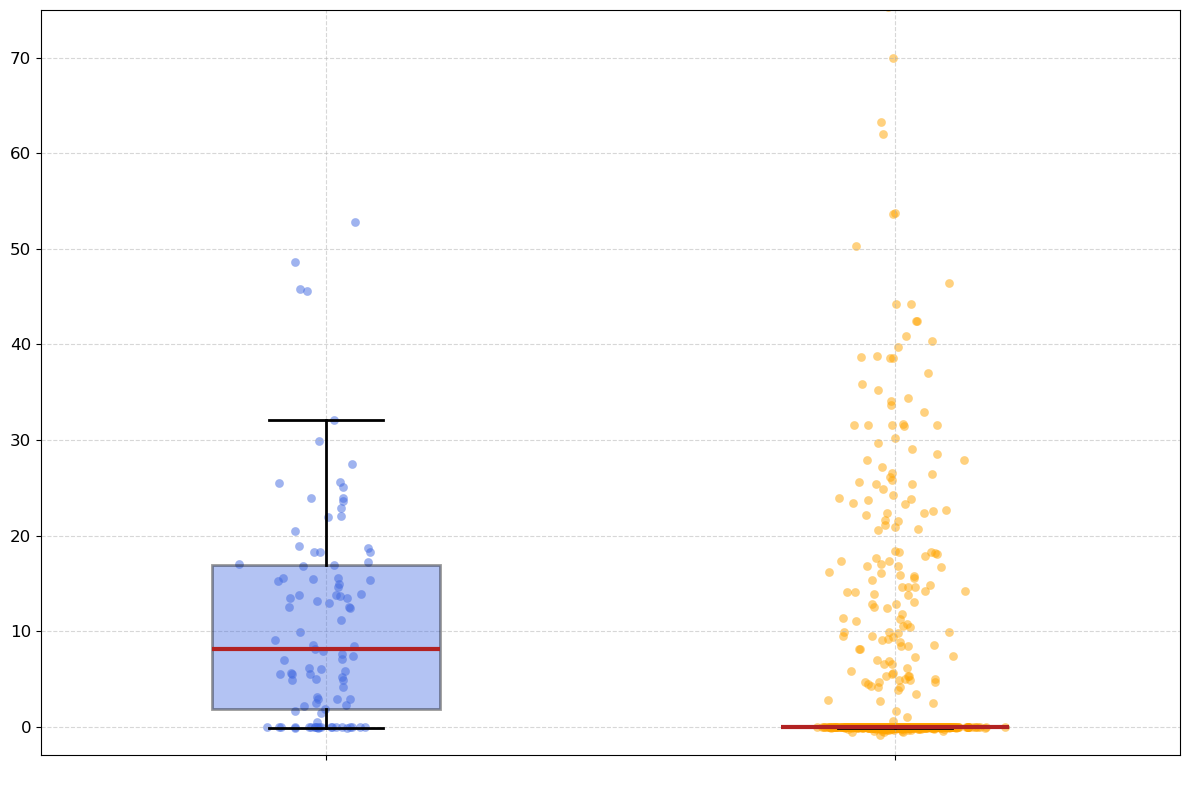

Number of WGD pairs: 101
Number of SSD pairs: 1241


In [20]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
plt.ylim(-3, 75)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_zscores_boxplot_{s}.jpg', bbox_inches='tight')
plt.show()

print(f"Number of WGD pairs: {len(df_wgd_lca_parsed)}")
print(f"Number of SSD pairs: {len(df_ssd_lca_parsed)}")

In [21]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
print(f"KS test results with parameters:\nnetwork={network}\ntarget_homology={target_homology}\nremove_pre_2R={remove_SSD_pre_2R}")
print(75 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
target_homology=mix
remove_pre_2R=False
KS statistic: 0.6596963483616693, p-value: 5.316946942836597e-40


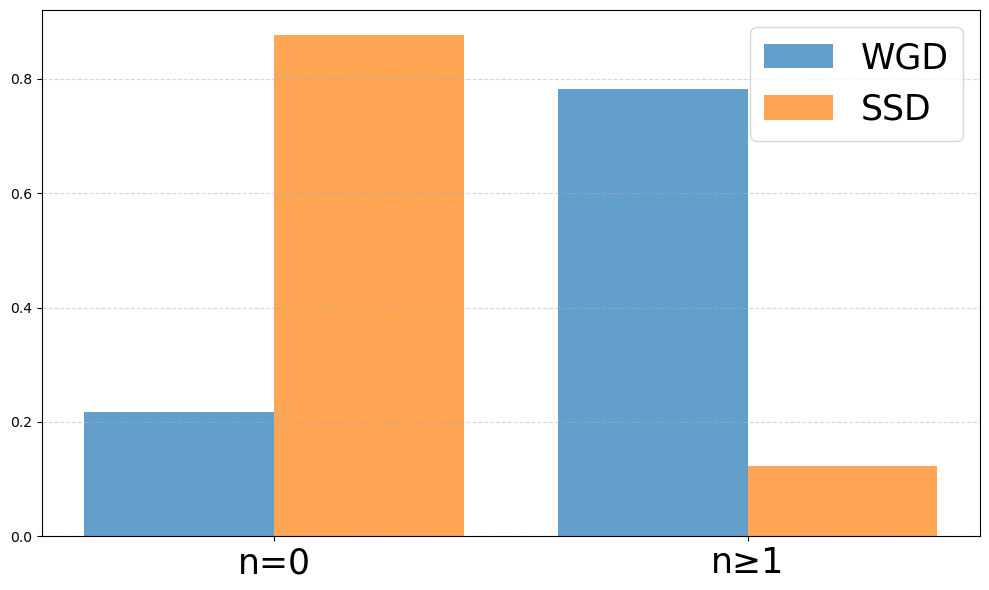

In [22]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_nmotif_barplot_{s}.pdf', bbox_inches='tight')
plt.show()

________________________________________

## Subgenome analysis

In [23]:
subg_file = '../../1.1_retrieve_Hsa_ohnomirnas/gnathostomata_ohnolog_reference_singlecol.gene.tsv'
df_subg = pd.read_csv(subg_file, sep='\t', header=None)
cols = ['miRNA', 'subgenome', 'CLG']
df_subg.columns = cols
df_subg

def label_subgenome(df_dup, df_subg, prefix):
    # Create a dictionary from df_subg (miRNA -> subgenome)
    subg_dict = dict(zip(df_subg['miRNA'], df_subg['subgenome']))

    # Function to translate and label each miRNA
    def translate_miRNA(miRNA):
        miRNA_clean = miRNA.replace(prefix, "")
        return subg_dict.get(miRNA_clean, 'unknown')

    # Apply subgenome labels
    df_dup_cp = df_dup.copy()
    df_dup_cp['subg_1'] = df_dup_cp['miRNA_1'].apply(translate_miRNA)
    df_dup_cp['subg_2'] = df_dup_cp['miRNA_2'].apply(translate_miRNA)

    # Split into numeric and Greek part
    df_dup_cp['miRNA_1_1R'] = df_dup_cp['subg_1'].str.extract(r'(\d)')
    df_dup_cp['miRNA_1_2R'] = df_dup_cp['subg_1'].str.extract(r'(alpha|beta)')

    df_dup_cp['miRNA_2_1R'] = df_dup_cp['subg_2'].str.extract(r'(\d)')
    df_dup_cp['miRNA_2_2R'] = df_dup_cp['subg_2'].str.extract(r'(alpha|beta)')

    return df_dup_cp

df_wgd_lca_parsed_subg = label_subgenome(df_wgd_lca_parsed, df_subg, '')

n_1 =  32
n_2 =  33
n_3 =  27
n_4 =  9


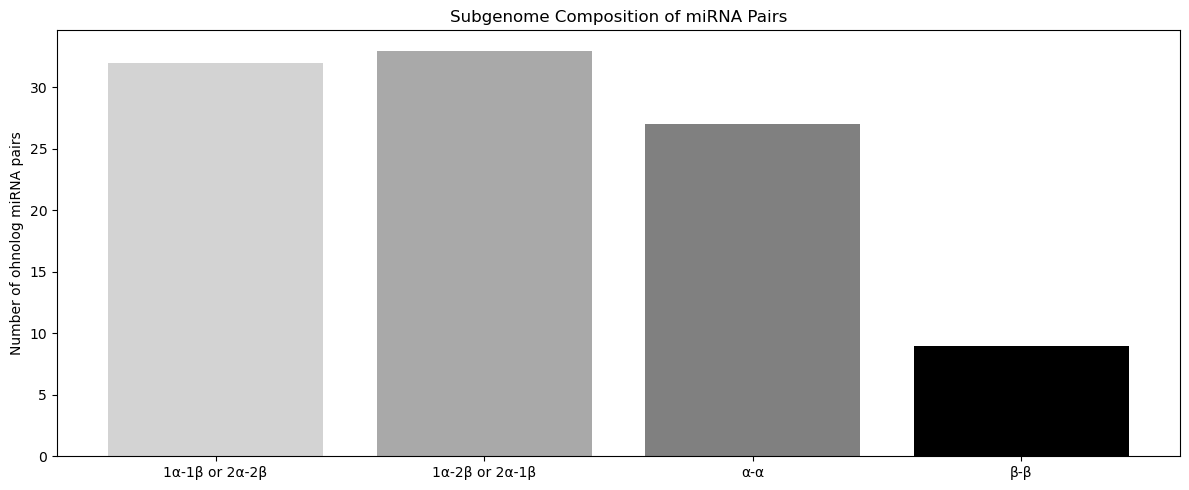

In [24]:
mask_1 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] == df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_2 = (
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R'])) |
    ((df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_1_1R'] != df_wgd_lca_parsed_subg['miRNA_2_1R']))
)

mask_3 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'alpha') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'alpha') 
)

mask_4 = (
	(df_wgd_lca_parsed_subg['miRNA_1_2R'] == 'beta') & (df_wgd_lca_parsed_subg['miRNA_2_2R'] == 'beta') 
)

# add a column named "dup_subgenome_type" with "A" if mask_1 is True, "B" if mask_2 is True, and "C" if mask_3 is True
df_wgd_lca_parsed_subg['dup_subgenome_type'] = np.select(
	[mask_1, mask_2, mask_3, mask_4],
	['A', 'B', 'C', 'D']
)

n_1 = df_wgd_lca_parsed_subg[mask_1].shape[0]
n_2 = df_wgd_lca_parsed_subg[mask_2].shape[0]
n_3= df_wgd_lca_parsed_subg[mask_3].shape[0]
n_4 = df_wgd_lca_parsed_subg[mask_4].shape[0]

print("n_1 = ", n_1)
print("n_2 = ", n_2)
print("n_3 = ", n_3)
print("n_4 = ", n_4)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(['1α-1β or 2α-2β', '1α-2β or 2α-1β', 'α-α', 'β-β'], [n_1, n_2, n_3, n_4], color=['lightgrey', 'darkgrey', 'grey', 'black'])
plt.ylabel('Number of ohnolog miRNA pairs')
plt.title('Subgenome Composition of miRNA Pairs')
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_subgenome_numbers_{s}.jpg', bbox_inches='tight')
plt.show()

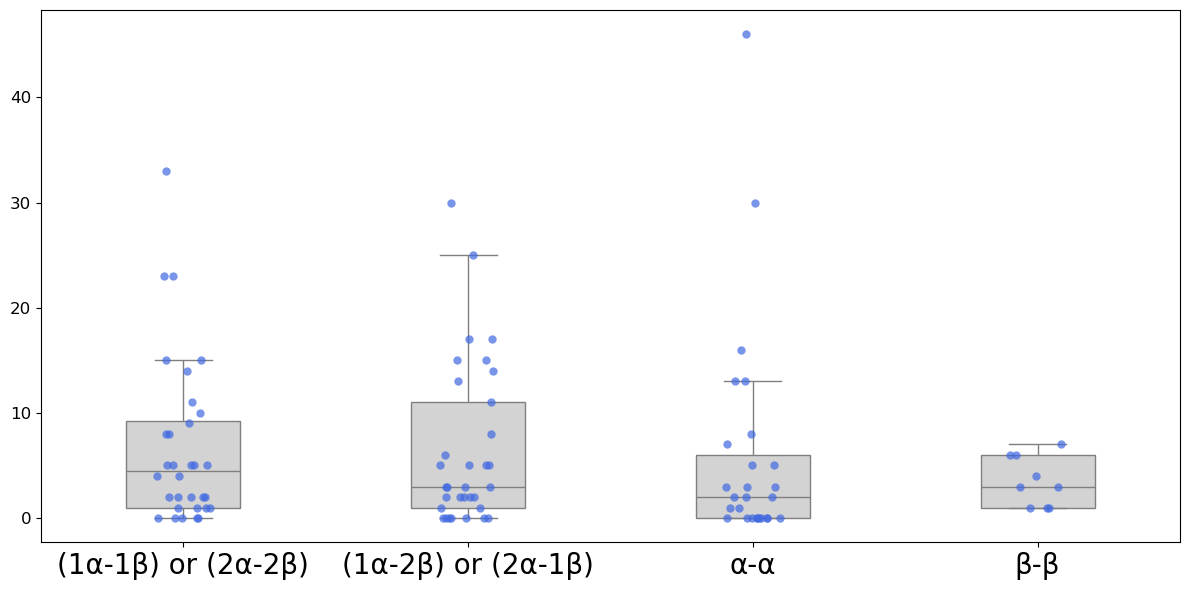

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='n_relevant_bifan', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.7, s=6, jitter=True)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.title('', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_subgenome_nbifan_{s}.jpg', bbox_inches='tight')
plt.show()

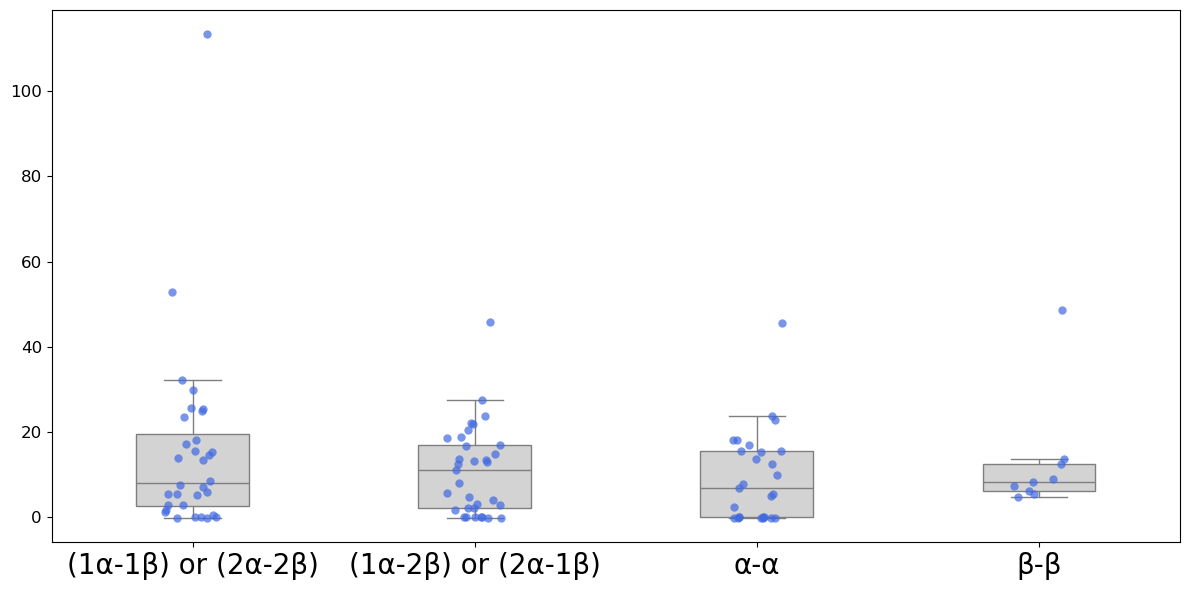

In [26]:
plt.figure(figsize=(12, 6))
df_wgd_lca_parsed_subg['Z-score'] = pd.to_numeric(df_wgd_lca_parsed_subg['Z-score'], errors='coerce')
sns.boxplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg,
			order=['A', 'B', 'C', 'D'], showfliers=False, width=0.4, linewidth=1, color='lightgrey')
sns.stripplot(x='dup_subgenome_type', y='Z-score', data=df_wgd_lca_parsed_subg, 
			order=['A', 'B', 'C', 'D'], color='royalblue', alpha=0.7, s=6)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.title('', fontsize=16)
plt.xticks(ticks=range(len(v)), labels=v, fontsize=12)
plt.xticks(fontsize=20)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'../../local/pictures/bifan_subgenome_zscore_{s}.jpg', bbox_inches='tight')
plt.show()

In [27]:
# compute KS pvalues for each pair of subgenome types
def compute_ks_pvalue(df1, subg_type1, subg_type2):
	"""
	Computes the KS p-value for the Z-scores of two subgenome types.
	"""
	df1_subg = df1[df1['dup_subgenome_type'] == subg_type1]
	df2_subg = df1[df1['dup_subgenome_type'] == subg_type2]
	
	if df1_subg.empty or df2_subg.empty:
		return None, None
	
	ks_stat, ks_p_value = stats.ks_2samp(df1_subg['Z-score'].astype(float), df2_subg['Z-score'].astype(float))
	
	return ks_stat, ks_p_value

subg_types = ['A', 'B', 'C', 'D']
ks_results = {}
for i in range(len(subg_types)):
	for j in range(i + 1, len(subg_types)):
		subg_type1 = subg_types[i]
		subg_type2 = subg_types[j]
		ks_stat, ks_p_value = compute_ks_pvalue(df_wgd_lca_parsed_subg, subg_type1, subg_type2)
		if ks_stat is not None and ks_p_value is not None:
			ks_results[(subg_type1, subg_type2)] = (ks_stat, ks_p_value)

print("KS test results for subgenome types:")
for (subg_type1, subg_type2), (ks_stat, ks_p_value) in ks_results.items():
	print(f"Subgenome types: {subg_type1} vs {subg_type2} - KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results for subgenome types:
Subgenome types: A vs B - KS statistic: 0.1590909090909091, p-value: 0.7390621306197361
Subgenome types: A vs C - KS statistic: 0.21412037037037038, p-value: 0.4348138651865262
Subgenome types: A vs D - KS statistic: 0.3263888888888889, p-value: 0.3515546746234657
Subgenome types: B vs C - KS statistic: 0.16161616161616163, p-value: 0.7658844807934664
Subgenome types: B vs D - KS statistic: 0.3939393939393939, p-value: 0.17408406761272427
Subgenome types: C vs D - KS statistic: 0.4074074074074074, p-value: 0.18822741251420172


____________________

## Expression

In [28]:
dict_path = '../../1.1_retrieve_Hsa_ohnomirnas/ohnomirna_mgdb_to_gene.dic'

dic = {}
with open(dict_path) as f:
	for line in f:
		parts = line.strip().split('\t')
		if len(parts) == 2:
			dic[parts[1]] = parts[0]

In [29]:
avg_expr_matrix_path = '../../miRNATissueAtlas_expression/all_human_miRNA_rpmm_harmonized_meta_data.mgdb.csv'

with open(avg_expr_matrix_path) as f:
    lines = [line.strip().split('\t') for line in f.readlines()[:4]]
    
columns = list(zip(*lines))
merged_header = ['{},{}'.format(columns[i][0], ','.join(columns[i][1:])) for i in range(len(columns))]
h = '\t'.join(merged_header)

expr_df = pd.read_csv(avg_expr_matrix_path, index_col=None, sep='\t', header=None)
expr_df = expr_df.iloc[4:, :]
expr_df.columns = h.split('\t')
expr_df.set_index(expr_df.columns[0], inplace=True)
expr_df = expr_df[expr_df.index != 'unknown_mirna']
expr_df = expr_df[expr_df.index != 'premirna_not_in_mirgenedb']
expr_df = expr_df.apply(pd.to_numeric)
expr_df = expr_df.loc[:, expr_df.columns.str.endswith('mean')]

expr_df_norm = expr_df.div(expr_df.sum(axis=0), axis=1)
expr_df_norm

# filter only columns starting with "tissue,"
expr_df_norm_filtered = expr_df_norm.loc[:, expr_df_norm.columns.str.startswith("tissue,", "cell_line,")]

/tmp/ipykernel_1445/2647283964.py:10: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [30]:
def retrieve_expression(mirna, expr_df, dic):
    """
    Retrieves the expression values for a given miRNA from the expression DataFrame.
    If multiple entries exist (miRNA name duplicated), returns their average expression vector.
    """
    if mirna in dic:
        mirna = dic[mirna]

    if mirna in expr_df.index:
        expr_values = expr_df.loc[mirna]

        # Check if expr_values is a DataFrame (multiple rows with same miRNA name)
        if isinstance(expr_values, pd.DataFrame):
            # Average across duplicate rows
            expr_mean = expr_values.mean(axis=0).values
            return expr_mean.flatten()
        else:
            # Single row, return directly
            return expr_values.values.flatten()
    else:
        return None
	
def expression_correlation(expr_1, expr_2):
    """
    Calculates the cosine similarity between two expression vectors.
    Returns NaN if either vector is None, identical, or has insufficient data.
    """
    from scipy.spatial.distance import cosine

    if expr_1 is None or expr_2 is None:
        return np.nan
    if len(expr_1) < 2 or len(expr_2) < 2:
        return np.nan
    if np.array_equal(expr_1, expr_2):
        return np.nan
    
    m = 1 - cosine(expr_1, expr_2)

    return m

In [31]:
df_wgd_lca_parsed_subg_bifanonly = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['n_relevant_bifan'] > 0]

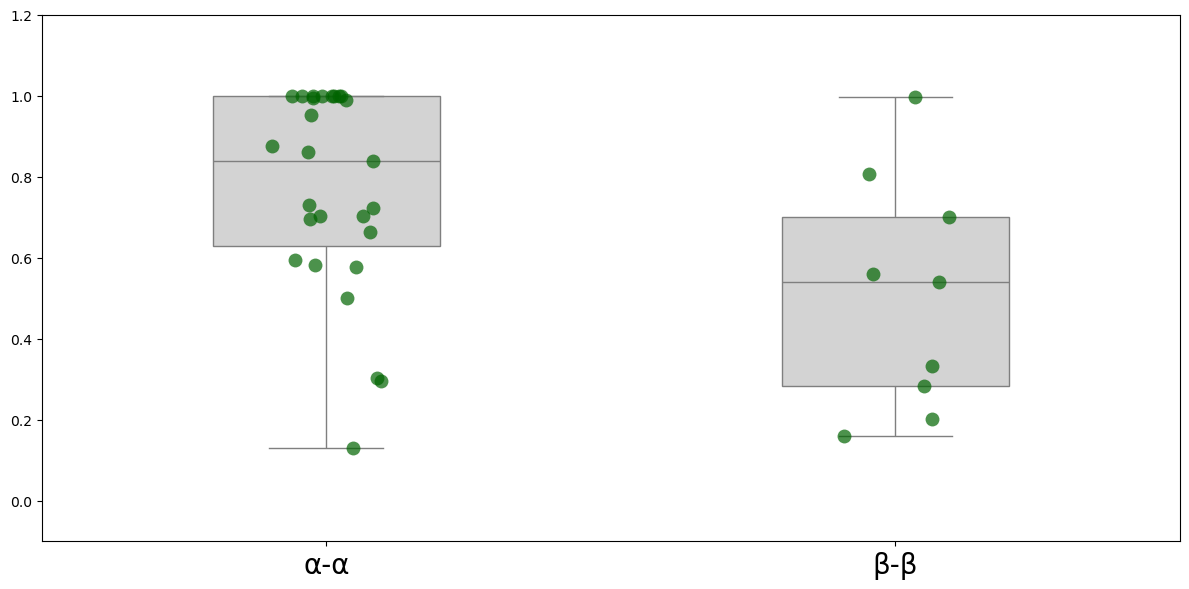


KS test results for expression correlations between subgenome pairs:
C vs D - KS statistic: 0.5185, p-value: 0.042175501002302024


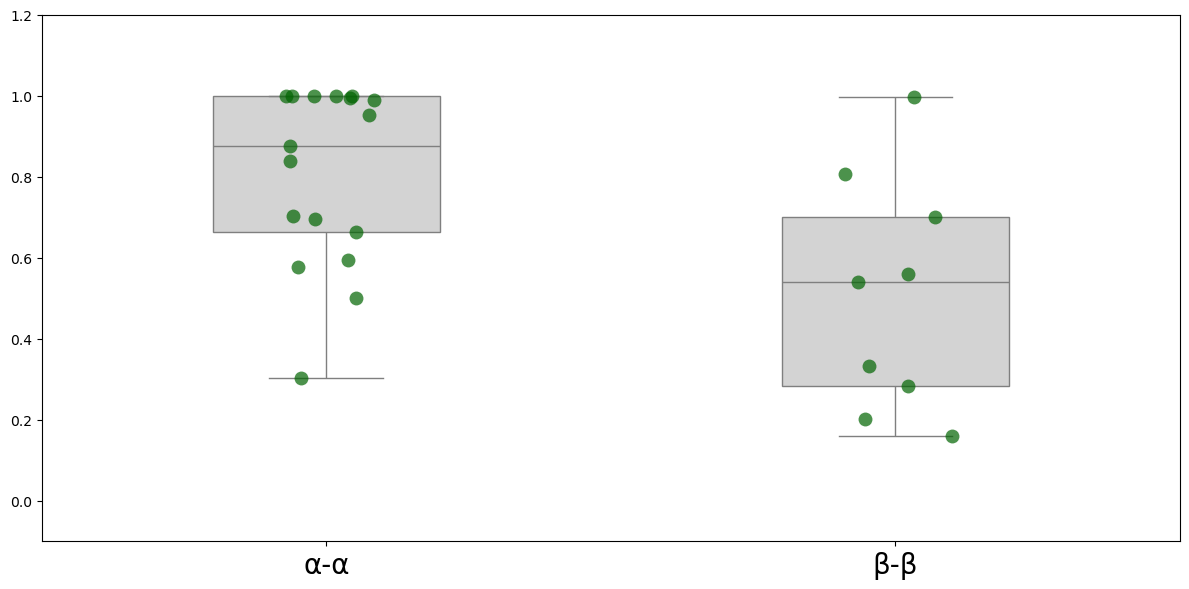


KS test results for expression correlations between subgenome pairs:
C vs D - KS statistic: 0.5490, p-value: 0.032263845993823106


In [ ]:
def plot_expression_correlation(df, expr_df, dic):
    """
    Plots the expression correlation for each combination of subgenomes in the DataFrame.
    """
    #desired_order = ["A", "B", "C", "D"]
    desired_order = ["C", "D"]
    correlations = []

    for subg_type in desired_order:
        subg_df = df[df['dup_subgenome_type'] == subg_type]
        for _, row in subg_df.iterrows():
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((subg_type, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.4,
        linewidth=1,
        order=desired_order
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(-0.1, 1.2)
    plt.title('')
    #v = ['(1α-1β) or (2α-2β)', '(1α-2β) or (2α-1β)', 'α-α', 'β-β']
    v = ['α-α', 'β-β']
    plt.xticks(ticks=range(len(v)), labels=v, fontsize=20)
    plt.tight_layout()
    plt.show()
    
    ks_results = {}
    for i in range(len(desired_order)):
        for j in range(i + 1, len(desired_order)):
            type1 = desired_order[i]
            type2 = desired_order[j]
            corrs_type1 = corr_df[corr_df['subgenome_pair'] == type1]['correlation']
            corrs_type2 = corr_df[corr_df['subgenome_pair'] == type2]['correlation']

            if corrs_type1.empty or corrs_type2.empty:
                continue

            ks_stat, ks_pvalue = ks_2samp(corrs_type1, corrs_type2)
            ks_results[(type1, type2)] = (ks_stat, ks_pvalue)

    print("\nKS test results for expression correlations between subgenome pairs:")
    for (type1, type2), (ks_stat, ks_pvalue) in ks_results.items():
        print(f"{type1} vs {type2} - KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue}")
        
plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic)
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic)

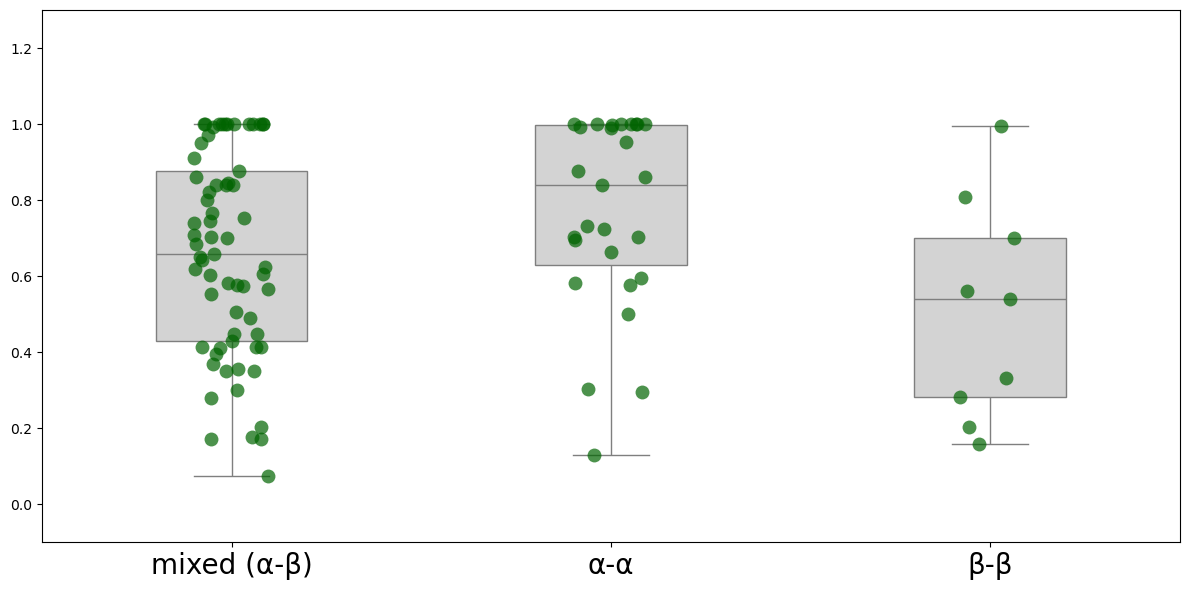


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.2484, p-value: 0.1554800218638869
mixed vs D - KS statistic: 0.3368, p-value: 0.2631481245337442
C vs D - KS statistic: 0.5185, p-value: 0.042175501002302024


/tmp/ipykernel_1445/4027000323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B'] else x)


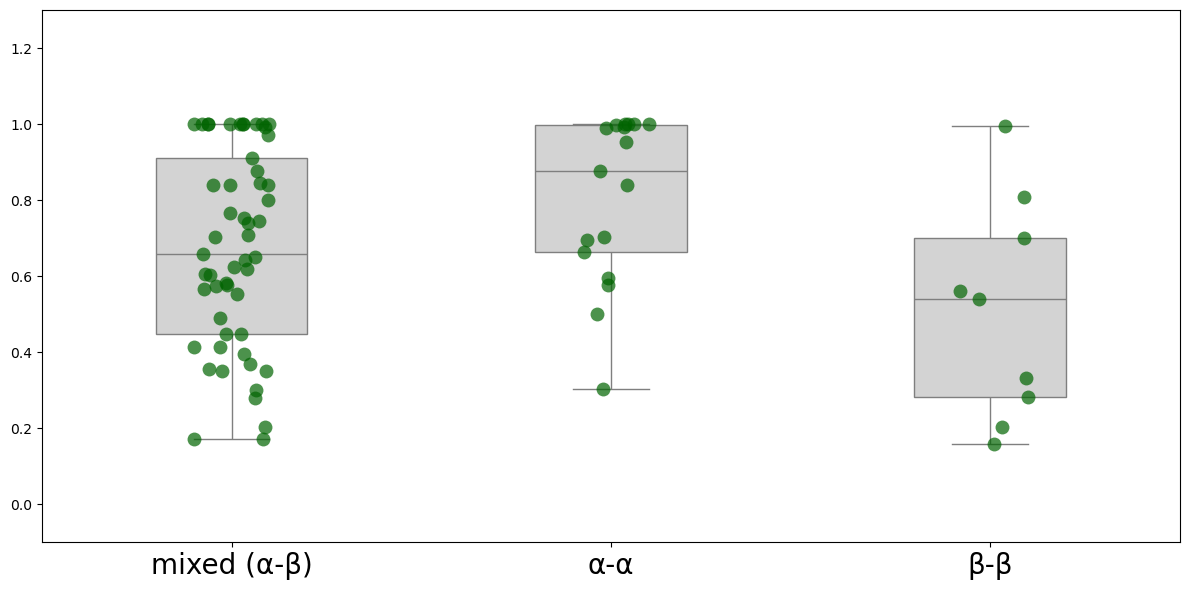


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.2741, p-value: 0.23756541614163262
mixed vs D - KS statistic: 0.3648, p-value: 0.1974902908368203
C vs D - KS statistic: 0.5490, p-value: 0.032263845993823106


In [33]:
def plot_expression_correlation(df, expr_df, dic):
    """
    Plots the expression correlation comparing 'mixed' (A and B combined), 'C', and 'D' subgenome types.
    """
    df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B'] else x)
    desired_order = ['mixed', 'C', 'D']
    label_map = {'mixed': 'mixed (α-β)', 'C': 'α-α', 'D': 'β-β'}
    correlations = []

    for group in desired_order:
        group_df = df[df['group'] == group]
        for _, row in group_df.iterrows():
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((group, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.4,
        linewidth=1,
        order=desired_order
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(-0.1, 1.3)
    plt.title('')
    xtick_labels = [label_map[g] for g in desired_order]
    plt.xticks(ticks=range(len(xtick_labels)), labels=xtick_labels, fontsize=20)
    plt.tight_layout()
    plt.show()

    # Compute pairwise KS p-values for correlation distributions
    from scipy.stats import ks_2samp

    ks_results = {}
    for i in range(len(desired_order)):
        for j in range(i + 1, len(desired_order)):
            type1 = desired_order[i]
            type2 = desired_order[j]
            corrs_type1 = corr_df[corr_df['subgenome_pair'] == type1]['correlation']
            corrs_type2 = corr_df[corr_df['subgenome_pair'] == type2]['correlation']

            if corrs_type1.empty or corrs_type2.empty:
                continue

            ks_stat, ks_pvalue = ks_2samp(corrs_type1, corrs_type2)
            ks_results[(type1, type2)] = (ks_stat, ks_pvalue)

    print("\nKS test results for expression correlations between subgenome pairs:")
    for (type1, type2), (ks_stat, ks_pvalue) in ks_results.items():
        print(f"{type1} vs {type2} - KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue}")

plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic)
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic)

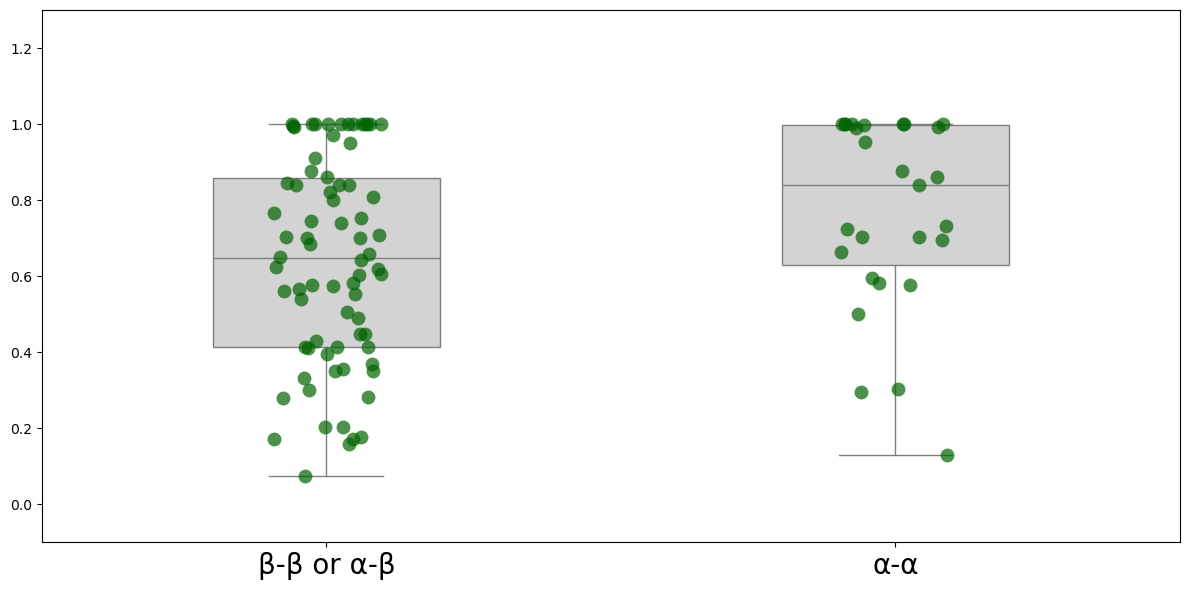


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.2678, p-value: 0.09510883907803674


/tmp/ipykernel_1445/3025274585.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B', 'D'] else x)


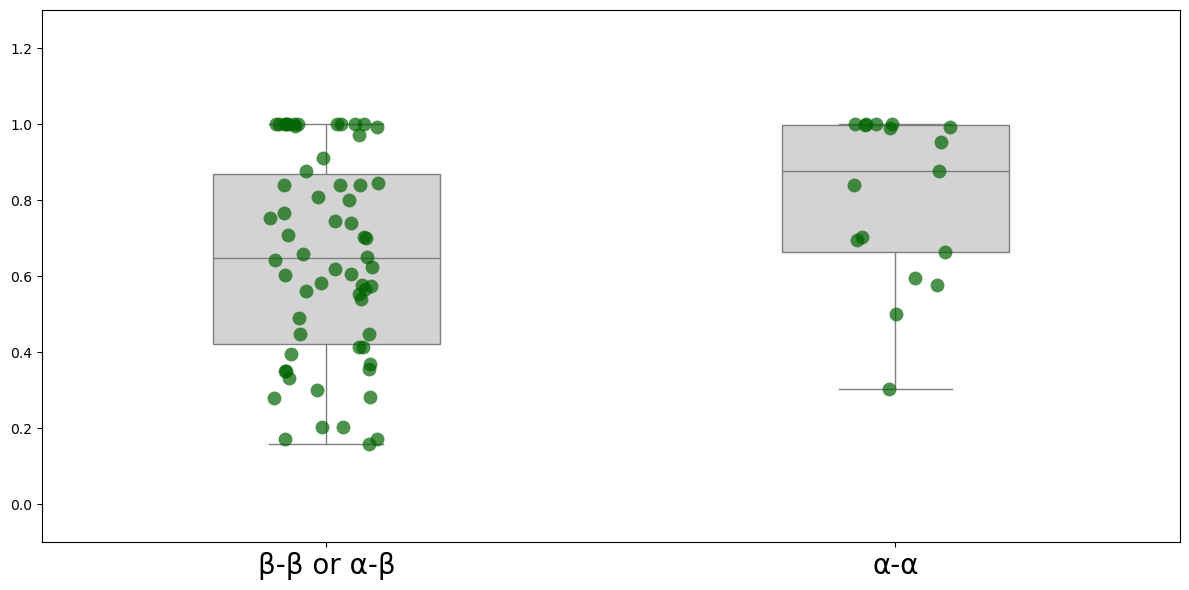


KS test results for expression correlations between subgenome pairs:
mixed vs C - KS statistic: 0.2970, p-value: 0.15276339702931066


In [34]:
def plot_expression_correlation(df, expr_df, dic):
    """
    Plots the expression correlation comparing 'mixed' (A and B combined), 'C', and 'D' subgenome types.
    """
    df['group'] = df['dup_subgenome_type'].apply(lambda x: 'mixed' if x in ['A', 'B', 'D'] else x)
    desired_order = ['mixed', 'C']
    label_map = {'mixed': 'β-β or α-β', 'C': 'α-α'}
    correlations = []

    for group in desired_order:
        group_df = df[df['group'] == group]
        for _, row in group_df.iterrows():
            expr_1 = retrieve_expression(row['miRNA_1'], expr_df, dic)
            expr_2 = retrieve_expression(row['miRNA_2'], expr_df, dic)

            corr = expression_correlation(expr_1, expr_2)

            if np.isnan(corr):
                print(f"Skipping pair ({row['miRNA_1']}, {row['miRNA_2']}), missing expression data.")
                continue

            correlations.append((group, corr))

    corr_df = pd.DataFrame(correlations, columns=['subgenome_pair', 'correlation'])

    if corr_df.empty:
        print("No valid correlations to plot. Check your miRNA mappings and expression DataFrame.")
        return

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        showfliers=False,
        color='lightgrey',
        width=0.4,
        linewidth=1,
        order=desired_order
    )
    sns.stripplot(
        x='subgenome_pair',
        y='correlation',
        data=corr_df,
        color='darkgreen',
        alpha=0.7,
        s=10,
        jitter=True,
        order=desired_order
    )
    plt.xlabel('')
    plt.ylabel('')
    plt.ylim(-0.1, 1.3)
    plt.title('')
    xtick_labels = [label_map[g] for g in desired_order]
    plt.xticks(ticks=range(len(xtick_labels)), labels=xtick_labels, fontsize=20)
    plt.tight_layout()
    plt.show()

    # Compute pairwise KS p-values for correlation distributions
    from scipy.stats import ks_2samp

    ks_results = {}
    for i in range(len(desired_order)):
        for j in range(i + 1, len(desired_order)):
            type1 = desired_order[i]
            type2 = desired_order[j]
            corrs_type1 = corr_df[corr_df['subgenome_pair'] == type1]['correlation']
            corrs_type2 = corr_df[corr_df['subgenome_pair'] == type2]['correlation']

            if corrs_type1.empty or corrs_type2.empty:
                continue

            ks_stat, ks_pvalue = ks_2samp(corrs_type1, corrs_type2)
            ks_results[(type1, type2)] = (ks_stat, ks_pvalue)

    print("\nKS test results for expression correlations between subgenome pairs:")
    for (type1, type2), (ks_stat, ks_pvalue) in ks_results.items():
        print(f"{type1} vs {type2} - KS statistic: {ks_stat:.4f}, p-value: {ks_pvalue}")

plot_expression_correlation(df_wgd_lca_parsed_subg, expr_df_norm_filtered, dic)
plot_expression_correlation(df_wgd_lca_parsed_subg_bifanonly, expr_df_norm_filtered, dic)